<a href="https://colab.research.google.com/github/bgola/coding-dojo-gencomp-udk/blob/master/CLIP_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/CLIP.git -q
!pip install kornia -q

In [ ]:
import torch 
import clip
from PIL import Image
import numpy as np
from torchvision.transforms import Normalize
import torch.nn.functional as F
import kornia.augmentation as K
import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 258MiB/s]


In [ ]:
def make_cutn(input, cut_size=224, n_cuts=64):
  clip_size = model.visual.input_resolution
  imsize = input.shape
  max_in = min(*imsize[2:]) - cut_size
  min_in = min(*imsize[2:],cut_size)
  cutouts = []
  for i in range(n_cuts):
    size = torch.randint(size=[1],low=min_in,high=max_in)[0]
    offsetx = torch.randint(0,imsize[3]-size+1,())
    offsety = torch.randint(0,imsize[2]-size+1,())
    cutout = input[:, :, offsety:offsety+size, offsetx:offsetx+size]
    cutout = F.interpolate(cutout,(clip_size,clip_size), mode='bilinear')
    cutouts.append(cutout)
  return torch.cat(cutouts)

aug = torch.nn.Sequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomSharpness(0.3,p=0.4),
    K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
    K.RandomPerspective(0.2,p=0.4),
    K.ColorJitter(hue=0.01, saturation=0.01, p=0.7)
    )

def to_image(x):
  img = x.detach().cpu().clip(0,1).permute(1,2,0).numpy() * 255
  img = img.astype(np.uint8)
  return Image.fromarray(img)

our_preprocess =  Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

In [ ]:
txt = ["a dog sitting on the table"]
text = clip.tokenize(txt).to(device)
text_features = model.encode_text(text)

In [ ]:
def gen(x, size=224):
  img = 0
  for i in range(len(x)):
      img += F.interpolate(x[i],(size,size), mode='bilinear')
  img /=len(x)
  img = torch.sigmoid(img)
  return img

In [ ]:
x1 = torch.randn((3,1024,1024), requires_grad=True).unsqueeze(0).to(device)
x2 = torch.randn((3,256,256), requires_grad=True).unsqueeze(0).to(device)
x3 = torch.randn((3,64,64), requires_grad=True).unsqueeze(0).to(device)
x4 = torch.randn((3,16,16), requires_grad=True).unsqueeze(0).to(device)

x = [x1,x2,x3,x4]

In [ ]:
for i in tqdm.trange(100):
  img = gen(x, size=1024)
  if i > 10:
    img = make_cutn(img, cut_size=100)
  else:
    img = F.interpolate(img,(224,224), mode='bilinear')
  
  img = aug(img)
  x_pre = our_preprocess(img)
  image_features = model.encode_image(x_pre)
  loss = (image_features-text_features).square().sum()
  grad = torch.autograd.grad(loss,x)
  for i in range(len(grad)):
    x[i] = x[i] - grad[i] 


100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


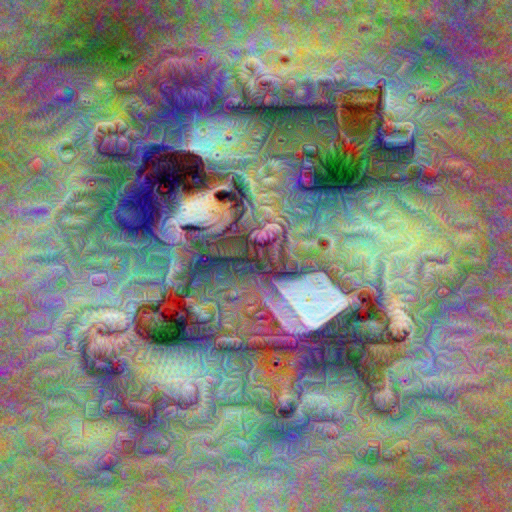

In [ ]:
img = gen(x, size=512)
to_image(img[0])

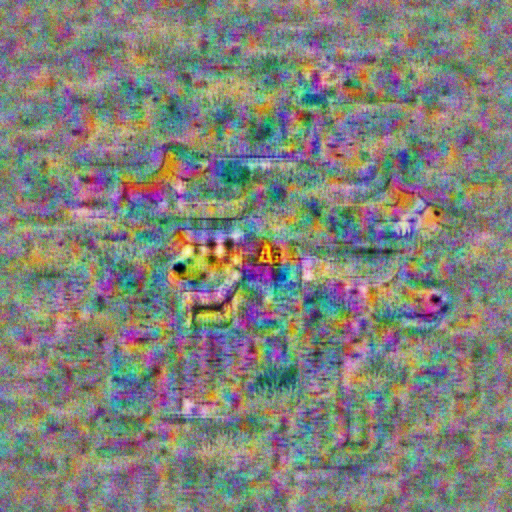

In [ ]:
img = gen(x, size=512)
to_image(img[0])

In [ ]:
img.max()

tensor(1.7408, device='cuda:0', grad_fn=<MaxBackward1>)